# Fresh Idea
## separate one/zero activity of domains
- replace zeros by minus one
- calculate the class activity for 3 hours bins for each domain
- calculate the user activity for gaussian around center of 3 hour bins
- calculate the likelihood of the person being a 1/-1 in that time 
- add user general metrics including domain cls activity and usage patterns

### questions
- how to take into account times when the person used a website when others didnt?
- how to give likelihood when the person didn't show any nearby activity?
- what if he used a similar website at same time but more nich? 
- how to average the bins weighted by the significance of that bin?
- how to give weight to the magnitude of number of users entering? probability of 1 with confidence
- what about sparse websites?
- how to not let times where there are no activity take a lot of weight?
### enhancements
- create graph embedding of urls
- for each bin, calculate the metric per url
- instead of only looking at the specific website, take into account websites with similar usages,
  for example looking at same domain_cls usage in gaussian around bin, or looking at domain embeddings and looking at the activity in similar embeddings weighted by the distance in the embedding space

### NOTICE:
the data itself will use all domains, even ones that the person never used. this could be an issue. 
first of all the fact that the person doesnt use them is an indication. we 
- we might want to take the niche websites and sum them up
- we might want to remove them

IDEA!
- use different features for different people
- make an ensemble that can differentiate between different users
- take the people that get a wrong prediction and see if a classifier that is more "fringe" can classify them better
- for example another tree classifier that takes a smaller amount of features to give more opportunity to fringe websites
can create a classifier for each user type 
can take number of usages for each domain, and cluster people or PCA
clustering is good - I can create a classifier for each cluster, from each cluster take all of the available data for all of the visited domains, and create a classifier for them. use only data from those users or all users that used one of the websites, plus the general model, for each cluster - use cluster model and general model.
also - I can multiply the features by the log of usages

another idea is to simply average the most prominent websites weighted by the specific user usages, and the general usage

USER CLUSTER AS FEATURE - or PCA coefficients

an idea - see how chaotic are the subject's patterns, if it's too predictable then it might be a bot


### Environment Initialization

In [ ]:
import sys
sys.path.append("/home/tom.touati/mafat-challenge/code/submission")
import importlib
import os
import ray
from modin.config import NPartitions,RangePartitioning
%matplotlib widget
os.environ["NEPTUNE_API_TOKEN"] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMGMyZjIyZC0xMjQzLTQxNjQtYjZjZC0wMTRiZmJmZmRlZjYifQ=="
    # !export MODIN_CPUS=2
# n_cpus = 8
plasma_store_size = 100*(1024**3)
heap_memory = 210*(1024**3)
# os.environ["MODIN_CPUS"] = str(n_cpus)
# os.environ["MODIN_ENGINE"] = "ray"
os.environ["MODIN_NPARTITIONS"] = "32"
os.environ["MODIN_RANGE_PARTITIONING"] = "True"
# os.environ["MODIN_MEMORY"] = str(plasma_store_size)
ray.init(num_cpus =32,ignore_reinit_error=True, object_store_memory=plasma_store_size,_memory=heap_memory)
# print(ray.cluster_resources())
import modin.pandas as mpd
from modin import config as cfg
print(vars(cfg))
NEPTUNE_MODE="sync"
params={}
%load_ext autoreload
%autoreload 2

### Data Loading & Preparation

In [ ]:
%%writefile submission/load_and_prepare_input.py
import os
import sqlite3
# %matplotlib widget
import matplotlib.pyplot as plt
from multiprocessing import freeze_support
from modin.db_conn import ModinDatabaseConnection
import modin.pandas as mpd
  # Modin will use Ray
# ray.init()
# NPartitions.put(16)
def load_data_from_db(con,domain_cls=False,only_domain=False):
    try:
        additional_query = ""
        if domain_cls:
            additional_query = ",Domain_cls1,Domain_cls2,Domain_cls3,Domain_cls4"
        device_ids_query = f"""SELECT Domain_Name, Device_ID, Target,Datetime{additional_query} from data"""
        
        if only_domain:
            device_ids_query = f"""SELECT Domain_Name{additional_query} from data"""
        # WHERE Domain_Name != 1732927 """
        df = mpd.read_sql(device_ids_query, con
                         )._repartition()
        df = df[df['Domain_Name'] != 1732927]
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def load_and_prepare_data():
    freeze_support()
    dbfile = '../../data/training_set.db'

    conn = ModinDatabaseConnection('sqlalchemy', f'sqlite:///{dbfile}')

    # Can use get_connection to get underlying sqlalchemy engine
    conn.get_connection()
    db_df = load_data_from_db(conn)
    print(db_df.head())
    del conn
    db_df['Datetime'] = mpd.to_datetime(db_df['Datetime'])
    db_df.set_index('Datetime', inplace=True)
    db_df = db_df.astype( {'Domain_Name': 'uint32', 'Device_ID': 'uint32', 'Target': 'uint8'})
    return db_df
def get_cls_data(db_df=None):
    """
    Feature engeinering: For each Device_ID calculate the proportions of all the domain_cls he entered.

    Parameters
    ----------
    conn: connection
        A connection object to the database.
    device_list : list
        A list of Device_IDs to calculate their proportions.

    Returns
    -------
    dataframe
        A dataframe with the proportions for each Device_IDs and Domain_cls.
    """
    if db_df is not None:
        return db_df[['Device_ID', "Domain_cls1",
                    "Domain_cls2",
                    "Domain_cls3",
                    "Domain_cls4"]]
    freeze_support()
    dbfile = '../../data/training_set.db'

    conn = ModinDatabaseConnection('sqlalchemy', f'sqlite:///{dbfile}')

    # Can use get_connection to get underlying sqlalchemy engine
    conn.get_connection()
    sql = '''SELECT
                    Device_ID,
                    Domain_Name,
                    Domain_cls1,
                    Domain_cls2,
                    Domain_cls3,
                    Domain_cls4
                    from data
                    where Domain_Name != 1732927 and Domain_cls1 != 0 and Domain_cls2 != 0 and Domain_cls3 != 0 and Domain_cls4 != 0
                    '''

    df = mpd.read_sql(sql,conn, columns = ['Device_ID', "Domain_cls1",
                    "Domain_cls2",
                    "Domain_cls3",
                    "Domain_cls4"])
    
    return df
# prepare training data
import matplotlib.pyplot as plt
#train test split
from sklearn.model_selection import train_test_split
def get_train_test_devices(device_target_df, test_size=0.2, random_state=43):    
    # Perform stratified split on device IDs
    train_device_ids, test_device_ids = train_test_split(
        device_target_df['Device_ID'],
        test_size=test_size,
        random_state=random_state,
        stratify=device_target_df['Target']
    )
    return train_device_ids, test_device_ids

def get_initial_train_data(db_df, test_size=0.2, random_state=42, min_domain_devices=10,n_devices_hist=False):
    device_targets = db_df.groupby("Device_ID")["Target"].first().reset_index()
    train_devices, test_device_ids = get_train_test_devices(device_targets,test_size=test_size,random_state=random_state)
    train_df = db_df[db_df["Device_ID"].isin(train_devices)]
    devices_per_domain = train_df.groupby("Domain_Name")["Device_ID"].nunique()
    
    domain_mask = devices_per_domain>min_domain_devices
    print(f"Percentage of domains with more than {min_domain_devices} devices: {domain_mask.mean()*100:.2f}%")
    devices_per_domain = devices_per_domain[domain_mask]
    if n_devices_hist:
        hist = devices_per_domain.hist()
        # run["plots/domain_devices_hist"].upload(neptune.types.File.as_image(hist.figure))
        plt.show()
    train_df = train_df[train_df["Domain_Name"].isin(devices_per_domain.index)]
    return train_df,train_devices,test_device_ids, device_targets, devices_per_domain

# Add this line

In [ ]:
from submission.domain_timeseries_processing import *
from submission.utils import *
from submission.load_and_prepare_input import *
from submission.prepare_and_train_model import *
from submission.content_based_features import *
from submission.frequency_base_feats import *

db_df = load_and_prepare_data()

params.update({"training_data": {
    "min_domain_devices": 10,
    "n_devices_hist": False,
    "test_size": 0.2,
    "random_state": 42
}})
train_df, train_devices, test_device_ids, device_targets, devices_per_valid_domain = get_initial_train_data(
    db_df, **params["training_data"])
train_df = train_df._repartition()

### Utils

In [ ]:

%%writefile submission/utils.py
import modin.pandas as mpd
from sklearn.preprocessing import MinMaxScaler,StandardScaler
def z_normalize_by_all(df,train_devices,per_column = True,fillval=0,scaler=None):
    if scaler is not None:
        df.iloc[:, :] = scaler.transform(
            df if per_column else df.values.reshape(-1, 1)).reshape(df.shape)
        if fillval:
            df.fillna(fillval,inplace=True)
        return
    scaler = StandardScaler()
    train_data = df.loc[train_devices]
    scaler.fit(train_data if per_column else train_data.values.reshape(-1, 1))

    # Transform all data using fitted scaler
    df.iloc[:, :] = scaler.transform(
        df if per_column else df.values.reshape(-1, 1)).reshape(df.shape)
    if fillval:
        df.fillna(fillval,inplace=True)
    params = {
        "mean_": float(scaler.mean_[0]),  # Convert to native Python float
        "var_": float(scaler.var_[0]),
        "scale_": float(scaler.scale_[0]),
        "n_samples_seen_": int(scaler.n_samples_seen_),
    }
    return params
def min_max_scale_all_values(df, train_devices, per_column=False,scaler=None):
    if scaler is not None:
        df.iloc[:, :] = scaler.transform(
            df if per_column else df.values.reshape(-1, 1)).reshape(df.shape)
        return
    # Create MinMaxScaler and fit on training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data = df.loc[train_devices]
    scaler.fit(train_data if per_column else train_data.values.reshape(-1, 1))

    # Transform all data using fitted scaler
    df.iloc[:, :] = scaler.transform(
        df if per_column else df.values.reshape(-1, 1)).reshape(df.shape)

    # Save scaler parameters as JSON
    scaler_params = {
        "min_": float(scaler.min_[0]),  # Convert to native Python float
        "scale_": float(scaler.scale_[0]),
        "data_min_": float(scaler.data_min_[0]),
        "data_max_": float(scaler.data_max_[0]),
        "data_range_": float(scaler.data_range_[0]),
        # Convert tuple to list for JSON
        "feature_range": list(scaler.feature_range)
    }
    return scaler_params

from sklearn.impute import KNNImputer# , IterativeImputer
from sklearn.linear_model import BayesianRidge
from scipy.sparse import csr_matrix
# from implicit.cpu.als import AlternatingLeastSquares
def impute_missing_values(final_scores_pivot,train_device_ids):
    # Use SoftImpute to fill missing values
    imputer = KNNImputer(n_neighbors=10)
    imputer.fit(final_scores_pivot.loc[train_device_ids])
    imputed_scores = imputer.transform(final_scores_pivot)
    # imputer = AlternatingLeastSquares(factors=10, regularization=0.01, iterations=10,random_state=0)
    # # imputer = MissForest(max_depth=6,max_features=0.8, random_state=0)
    # imputer.fit( user_items = csr_matrix(final_scores_pivot.loc[train_device_ids].values))
    
    # imputed_scores = imputer.recommend_all(csr_matrix(final_scores_pivot.values))
    return imputed_scores
import gc
import ctypes
import sys

def cleanup_memory():
    """
    Force cleanup of memory by:
    1. Running garbage collection
    2. Attempting to release memory back to OS
    """
    # Force garbage collection
    gc.collect()
    
    # Attempt to release memory back to the OS
    if sys.platform.startswith('linux'):
        libc = ctypes.CDLL('libc.so.6')
        # MALLOC_TRIM(0) releases memory back to OS if possible
        libc.malloc_trim(0)

### Domain Timeseries Base Features

In [ ]:
%%writefile submission/domain_timeseries_processing.py
import json
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from functools import partial


def process_activity_timeseries(domain_df, bin_hours=6, gaussian_filter=True, n_days_each_side=3, std=1.5, drop_na=True, drop_zeros=False):
    activity_per_3h = domain_df[["Device_ID"]].resample(
        f'{str(bin_hours)}h').nunique()
    activity_per_3h.rename(columns={"Device_ID": "Activity"}, inplace=True)
    # activity_per_3h = activity_per_3h.to_frame()

    # n_days_each_side * 24h / 3h_per_bin * 2 sides
    gaussian_window_hours = int(n_days_each_side*24/bin_hours*2)
    if gaussian_filter:
        activity_per_3h = activity_per_3h.rolling(
            window=gaussian_window_hours, win_type='gaussian', center=True, min_periods=1, closed="both").mean(std=std)
    if drop_na:
        activity_per_3h.dropna(inplace=True)
    if drop_zeros:
        activity_per_3h = activity_per_3h[activity_per_3h["Activity"] != 0]
    return activity_per_3h.round().astype(int)


def _calculate_p1_if_active(domain_activity_timeseries):
    domain_activity_timeseries["bin_activity"] = domain_activity_timeseries["Activity_0"] + \
        domain_activity_timeseries["Activity_1"]
    domain_activity_timeseries["total_domain_activity"] = (
        domain_activity_timeseries["target_domain_activity_0"]+domain_activity_timeseries["target_domain_activity_1"])
    domain_activity_timeseries["relative_bin_activity"] = domain_activity_timeseries["bin_activity"] / \
        domain_activity_timeseries["total_domain_activity"]
    domain_activity_timeseries["p_Active|0"] = domain_activity_timeseries["Activity_0"]/(
        domain_activity_timeseries["0_users"]
    )
    domain_activity_timeseries["p_active|1"] = domain_activity_timeseries["Activity_1"]/(
        domain_activity_timeseries["1_users"])
    domain_activity_timeseries["p_1"] = domain_activity_timeseries["1_users"]/(
        domain_activity_timeseries["0_users"]+domain_activity_timeseries["1_users"])
    domain_activity_timeseries["p_active"] = domain_activity_timeseries["bin_activity"]/(
        domain_activity_timeseries["0_users"]+domain_activity_timeseries["1_users"])
    domain_activity_timeseries["p_1|active"] = domain_activity_timeseries["p_active|1"]*(
        domain_activity_timeseries["p_1"]/domain_activity_timeseries["p_active"])
    pass


def get_domain_activity_timeseries(train_df, domain_ts_kwargs):
    process_domain_timeseries = partial(
        process_activity_timeseries, **domain_ts_kwargs)
    process_domain_timeseries.__name__ = process_activity_timeseries.__name__
    domain_timeseries = train_df[["Domain_Name", "Target", "Device_ID"]].groupby(
        ["Domain_Name", "Target"]).apply(process_domain_timeseries)
    domain_timeseries["activity_fraction"] = domain_timeseries.groupby(
        ["Domain_Name", "Target"]).transform(lambda x: x/x.sum())
    # Add the sum of activity as a new column
    domain_activity = domain_timeseries.groupby(
        ["Domain_Name", "Target"])[["Activity"]].sum()
    domain_activity = domain_activity.rename(
        columns={"Activity": "target_domain_activity"})
    # Merge the results
    domain_timeseries = domain_timeseries.merge(
        domain_activity, left_index=True, right_index=True)
    # Reset index to get Target as a column, then pivot to get Target as columns
    pivot_fraction_ts = domain_timeseries.reset_index().pivot(
        index=['Datetime', 'Domain_Name'],
        columns='Target'
    ).fillna(0)
    pivot_fraction_ts.columns = [
        f'{col[0]}_{col[1]}' for col in pivot_fraction_ts.columns]
    target_users_per_domain = train_df.groupby(["Domain_Name", "Target"])["Device_ID"].nunique(
    ).unstack().fillna(0).astype(int).rename(columns={0: "0_users", 1: "1_users"})
    pivot_fraction_ts = pivot_fraction_ts.reset_index("Datetime").join(
        target_users_per_domain, how="left").set_index("Datetime", append=True).swaplevel()
    _calculate_p1_if_active(pivot_fraction_ts)
    return pivot_fraction_ts


def get_user_activity_timeseries(db_df, user_ts_kwargs):
    process_user_timeseries = partial(
        process_activity_timeseries, **user_ts_kwargs)
    process_user_timeseries.__name__ = process_activity_timeseries.__name__
    user_timeseries = db_df[["Domain_Name", "Device_ID"]].groupby(
        ["Domain_Name", "Device_ID"]).apply(process_user_timeseries)
    # user_timeseries.index = mpd.MultiIndex.from_tuples(user_timeseries.index.to_list(),names=["Domain_Name","Device_ID","Datetime"])
    return user_timeseries


def get_user_domain_scores(domain_activity_timeseries, user_activity_timeseries):
    # Merge domain and user timeseries data more efficiently
    merged_timeseries_df = domain_activity_timeseries[["p_1|active", "bin_activity"]].reset_index().merge(
        user_activity_timeseries.reset_index(),
        how="inner",
        on=["Domain_Name", "Datetime"]
    ).set_index(["Datetime", "Domain_Name", "Device_ID"])

    # Filter for active periods first to reduce data size
    merged_timeseries_df = merged_timeseries_df[merged_timeseries_df["Activity"] > 0]._repartition(
    )

    # Calculate scores directly
    # Calculate relative activity using transform for vectorized operation
    group_sums = merged_timeseries_df.groupby(['Domain_Name', 'Device_ID'])[
        'bin_activity'].transform('sum')

    # Vectorized division
    merged_timeseries_df['relative_active_bins_activity'] = merged_timeseries_df['bin_activity'] / group_sums

    # Calculate weighted scores in one step
    merged_timeseries_df["weighted_score"] = (merged_timeseries_df["p_1|active"]) * \
        (merged_timeseries_df["relative_active_bins_activity"])

    # Get final scores with optimized groupby
    final_scores = merged_timeseries_df.groupby(
        ["Device_ID", "Domain_Name"])["weighted_score"].sum()

    # Create pivot table efficiently
    final_scores_pivot = final_scores.unstack()

    return final_scores_pivot


import matplotlib.pyplot as plt
import numpy as np
def get_weighted_final_scores(final_scores_pivot,domain_usage_proportion,fillna=True,square_usage=False):
    # plt.figure()
    mult = domain_usage_proportion[final_scores_pivot.columns
        ]
    if square_usage:
        mult = mult**2
    weighted_final_scores = final_scores_pivot.mul(mult)
    if fillna:
        weighted_final_scores.fillna(0,inplace=True)
    # target_features = device_targets.set_index("Device_ID").join(weighted_final_scores)
    # target_features.set_index("Target")[[int(x) for x in best_features if x.isnumeric()]].stack().groupby("Target").mean().plot(kind="bar")
    # plt.show()
    return weighted_final_scores
    # with open('submission/minmax_scaler.json', 'w') as f:
    #     json.dump(scaler_params, f)

In [ ]:
params.update({"domain_activity_timeseries": {
    "bin_hours": 6,
    "gaussian_filter": True,
    "n_days_each_side": 7,
    "std": 1.5,
    "drop_na": False,
    "drop_zeros": True
}})

params.update({"user_activity_timeseries": {
    "bin_hours": 6,
    "gaussian_filter": True,
    "n_days_each_side": 3,
    "std": 1.5,
    "drop_na": True,
    "drop_zeros": False
}})
domain_activity_timeseries = get_domain_activity_timeseries(
    train_df, params["domain_activity_timeseries"])


user_activity_timeseries = get_user_activity_timeseries(
    db_df.loc[db_df["Domain_Name"].isin(devices_per_valid_domain.index)], params["user_activity_timeseries"])

p_scores_df = get_user_domain_scores(
    domain_activity_timeseries, user_activity_timeseries)
p_scores_df -= 0.5
prob_score_scaler_params = min_max_scale_all_values(p_scores_df, train_devices)

In [7]:
# plt.figure()

# device_targets.set_index("Device_ID").loc[test_device_ids].join(df,how="inner").set_index("Target").stack().groupby("Target").hist(bins=100,alpha=0.5)
# plt.show()

### Content Usage Based Features

In [ ]:
%%writefile submission/content_based_features.py
import numpy as np
def get_domain_usage_proportion(db_df):
    res =  db_df.groupby("Device_ID")["Domain_Name"].value_counts(normalize=True).unstack(fill_value=0).astype(np.float32)
    return res

def get_cls_proportion(df):
    cols = ["Domain_cls1","Domain_cls2","Domain_cls3","Domain_cls4"]
    df = df.groupby("Device_ID")[cols].apply(lambda x: df.stack().value_counts(normalize=True).T.fillna(0).to_frame().T)

    
    df.columns = [f"cls_{col}" for col in df.columns]
    df.rename({"cls_Device_ID":"Device_ID"},axis=1,inplace=True)
    print("check if device id is in columns", "Device_ID" in df.columns)
    df.index = df.index.droplevel(-1)
    return df
def get_proportion_of_domains_visited(df):
    res = df.groupby("Device_ID")["Domain_Name"].nunique()/df["Domain_Name"].nunique()
    res.name = "n_domains"
    return res.to_frame()



In [ ]:
domain_usage_proportion = get_domain_usage_proportion(
    db_df.loc[db_df["Domain_Name"].isin(devices_per_valid_domain.index)])
domain_usage_proportion = np.log(1+domain_usage_proportion)
domain_usage_proportion = (
    (domain_usage_proportion.T)/domain_usage_proportion.T.max()).T
cls_data = get_cls_data()
cls_proportion = get_cls_proportion(cls_data)
del cls_data

### Frequency Based Features


In [ ]:

%%writefile submission/frequency_base_feats.py
import numpy as np
import modin.pandas as mpd
from sklearn.decomposition import PCA

def get_active_days_per_user(user_domain_ts):
    """
    Calculate the number of unique days each user had any activity.

    Args:
        user_domain_ts: MultiIndex Series with levels [Domain_Name, Device_ID, Datetime]

    Returns:
        Series with index Device_ID and values being number of unique active days
    """
    # Reset index to get Datetime as a column
    df = user_domain_ts.reset_index()

    # Convert Datetime to date (removing time component)
    df['Date'] = df['Datetime'].dt.date

    # Group by Device_ID and count unique dates where Activity > 0
    active_days = df[df['Activity'] > 0].groupby('Device_ID')['Date'].nunique()

    active_days = active_days.astype(int)
    active_days.name = "Active_Days"
    active_days = (active_days-active_days.min()
                   ) / (active_days.max()-active_days.min())*2-1
    return active_days


def get_activity_per_time_bin(df, bin_hours=3):
    # Convert datetime to time only
    # time_index = db_df.index.to_series().dt.time
    # df["time"] = time_index
    df_copy = df.copy()
    df_copy["time"] = db_df.index.to_series().dt.hour.astype(int)//bin_hours
    df_copy["day_part_activity"] = 0
    activity_per_time_range = df_copy[["Device_ID", "time", "day_part_activity"]].groupby(
        ["Device_ID", "time"]).count()
    activity_per_time_range["activity_fraction"] = activity_per_time_range.groupby("Device_ID").apply(lambda x: x/x.sum()).values
    activity_per_time_range = activity_per_time_range[["activity_fraction"]].reset_index()
    activity_per_time_range = activity_per_time_range.pivot(index="Device_ID",columns="time",values="activity_fraction")
    activity_per_time_range.columns = [f"time_{col}" for col in activity_per_time_range.columns]
    activity_per_time_range = (activity_per_time_range-activity_per_time_range.stack().min())/(activity_per_time_range.stack().max()-activity_per_time_range.stack().min())*2-1
    activity_per_time_range = activity_per_time_range.fillna(0)
    return activity_per_time_range  # .round().astype(int)
def get_device_domain_pca(user_activity_timeseries, n_components=100):
    # Calculate total entries per domain for each device
    domain_entries = user_activity_timeseries.reset_index()[['Device_ID', 'Domain_Name','Activity']].groupby(['Device_ID', 'Domain_Name'])['Activity'].sum()
    domain_entries_pivot = domain_entries.unstack(fill_value=0)
    # domain_entries_pivot = domain_entries_pivot/domain_entries_pivot.sum(axis=1)
    # Normalize the data
    # normalized_data = (domain_entries_pivot - domain_entries_pivot.min().min()) / (domain_entries_pivot.max().max() - domain_entries_pivot.min().min())
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(domain_entries_pivot.fillna(0))
    # Print explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio: {explained_variance.sum():.3f}")
    # Create DataFrame with PCA results
    pca_df = mpd.DataFrame(
        pca_result,
        index=domain_entries_pivot.index,
        columns=[f'pca_domain_{i}' for i in range(n_components)]
    )
    
    return pca_df
#activity fft
from scipy import fft
import numpy as np
from sklearn.preprocessing import StandardScaler
def get_ps_df(user_activity_timeseries,train_devices):
    total_user_activity = user_activity_timeseries.groupby(["Device_ID","Datetime"]).sum()
    total_user_activity = total_user_activity.unstack()
    total_user_activity = total_user_activity.fillna(0)
    power_spectrums = np.abs(fft.fft(total_user_activity.T.values))**2
    sample_d = 3*60*60
    
    freqs = fft.fftfreq(total_user_activity.shape[1],d=sample_d)
    freq_mask = freqs>=0
    power_spectrums = power_spectrums[freq_mask]
    freqs = freqs[freq_mask]

    psd_df = mpd.DataFrame(power_spectrums.T,index=total_user_activity.index,columns=freqs)
    # Get power spectra for training devices only
    train_psd = psd_df.loc[train_devices]

    # Create and fit scaler on training data
    scaler = StandardScaler()
    # scaler.fit(train_psd.T)

    # Transform all data using fitted scaler
    psd_df.iloc[:,:] = scaler.fit_transform(psd_df.values)
    
    return psd_df
# Convert to dataframe and normalize
# power_spectrums_df = power_spectrums.to_frame('power_spectrum')
# power_spectrums_df = (power_spectrums_df - power_spectrums_df.min()) / (power_spectrums_df.max() - power_spectrums_df.min())

In [ ]:

cleanup_memory()
psd_df = get_ps_df(user_activity_timeseries, train_devices)

domains_visited_proportion = get_proportion_of_domains_visited(
    db_df[db_df["Domain_Name"].isin(devices_per_valid_domain.index)])
domains_visited_scaler_params = z_normalize_by_all(
    domains_visited_proportion, train_devices, per_column=True, fillval=0)

array([[<Axes: title={'center': 'n_domains'}>]], dtype=object)

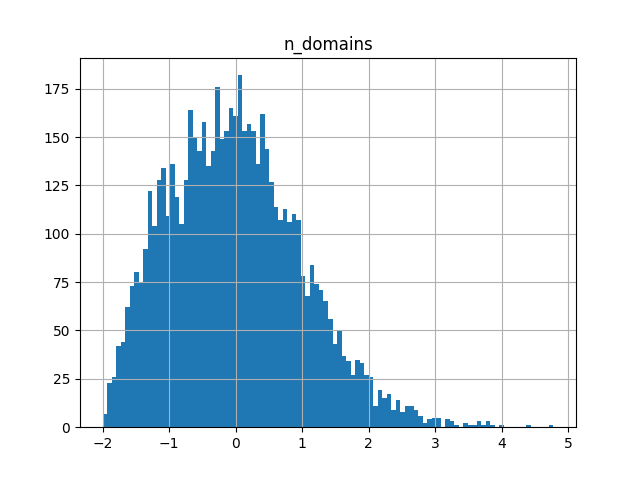

In [29]:
domains_visited_proportion.hist(bins=100)

In [ ]:

n_valid_sites_per_user = p_scores_df.notna().stack().groupby("Device_ID").mean()
scaler = z_normalize_by_all(n_valid_sites_per_user,
                            train_devices, per_column=False, fillval=0)
plt.figure()
n_valid_sites_per_user.hist(bins=100)
plt.show()

### Mixed Features

In [13]:
# # weighted_final_scores = get_weighted_final_scores(p_scores_df,domain_usage_proportion)
# domain_usage_copy = domain_usage_proportion.copy()
# domain_usage_copy.loc[p_scores_df.isna()] = np.nan
# domain_usage_copy = domain_usage_proportion.copy()
# p_scores_copy = p_scores_df.copy()

# # Set minimum domain usage threshold (adjust as needed)
# min_usage_threshold = 0.01

# # Create mask for domains meeting minimum usage
# usage_mask = domain_usage_proportion[p_scores_df.columns] >= min_usage_threshold

# # Apply domain usage filtering
# p_new = p_scores_copy.copy()
# p_new.loc[~usage_mask] = np.nan

# # Stack filtered results
# p = p_new.stack()

# # Optional: Add diagnostic prints
# print(f"Original shape: {p_scores_df.shape}")
# print(f"Filtered shape: {p_new.shape}")
# print(f"Final stacked entries: {len(p)}")

# # plt.figure()

# # (p_new.iloc[:,np.argmax(np.abs(p_new),axis=1)]
# #  ).join(device_targets.set_index("Device_ID")).set_index("Target"
# #     ).stack().groupby("Target").hist(bins=100,alpha=0.5)
# # plt.show()

In [14]:
params.update({"weighted_final_scores": {
    "fillna": True
}})
weighted_final_scores = get_weighted_final_scores(
    p_scores_df._repartition(), domain_usage_proportion._repartition())
scores_scaler = z_normalize_by_all(
    weighted_final_scores, train_devices, per_column=False)

In [39]:
params.update({"mean_probability_score": {
    "fillna": True,
    "square_usage": True
}})
mean_probability_score = get_weighted_final_scores(
    p_scores_df, domain_usage_proportion, **params["mean_probability_score"]).T.mean().to_frame()
mean_scores_scaler = z_normalize_by_all(
    mean_probability_score, train_devices, per_column=False)
# change this to sum,then divide by sum of usage

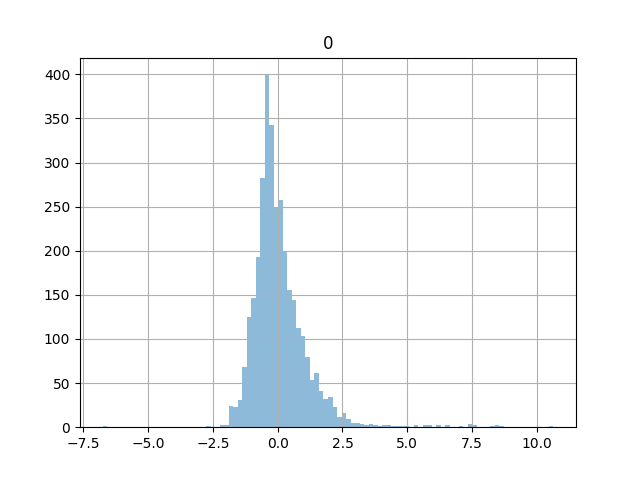

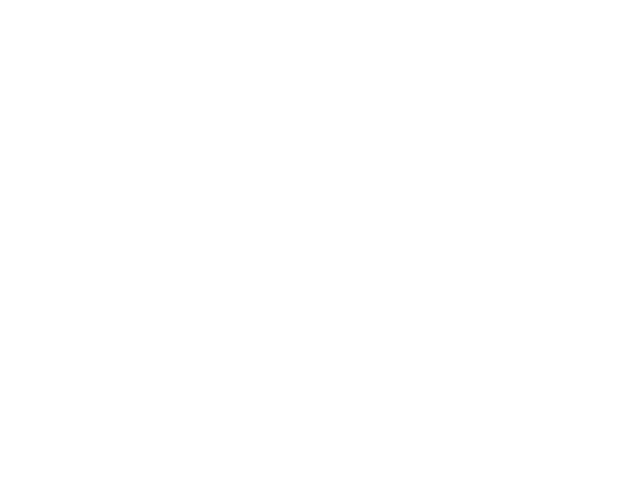

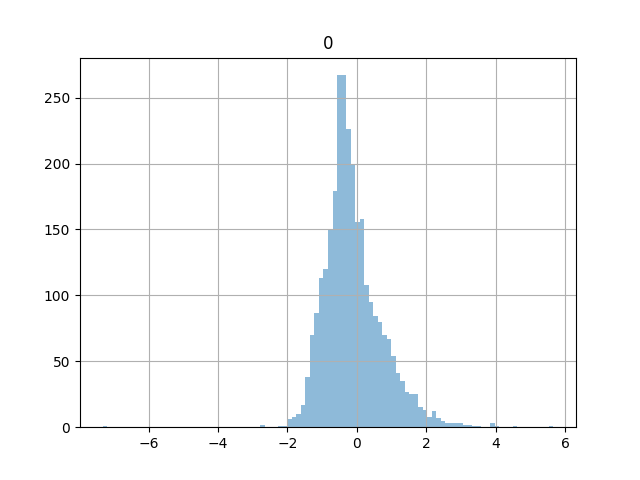

In [43]:
plt.figure()
device_targets.set_index("Device_ID").join(mean_probability_score).set_index(
    "Target").groupby("Target").hist(bins=100, alpha=0.5)
plt.show()

In [ ]:
plt.figure()
weighted_final_scores.join(device_targets.set_index("Device_ID")).set_index(
    "Target").stack().groupby("Target").hist(bins=100, alpha=0.5)
plt.show()

In [ ]:
plt.figure()
mean_probability_score.join(device_targets.set_index("Device_ID")).set_index(
    "Target").stack().groupby("Target").hist(bins=100, alpha=0.5, density=True)
plt.show()

### Preparation & Training

In [ ]:
%%writefile submission/prepare_and_train_model.py
# model training
import xgboost
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score


def join_features(device_targets, weighted_final_scores=None, domain_usage_proportion=None, 
                  cls_proportion=None, psd_df=None,domains_visited_proportion=None,mean_probability_score=None):
    final_features = device_targets.set_index("Device_ID")

    if weighted_final_scores is not None:
        final_features = final_features.join(weighted_final_scores.rename(columns = lambda x: "p_"+str(x)), how="left")
        
    if domain_usage_proportion is not None:  
        final_features = final_features.join(domain_usage_proportion.rename(columns = lambda x: "domain_usage_"+str(x)), how="left")
        
    if cls_proportion is not None:
        final_features = final_features.join(cls_proportion.rename(columns = lambda x: "cls_proportion_"+str(x)), how="left")
        
    if psd_df is not None:
        final_features = final_features.join(psd_df.rename(columns = lambda x: "activity_ps_"+str(x)), how="left")
        
    if domains_visited_proportion is not None:
        final_features = final_features.join(domains_visited_proportion.rename(columns = lambda x: "domains_visited_"+str(x)), how="left")
        
    if mean_probability_score is not None:
        final_features = final_features.join(mean_probability_score.rename(columns = lambda x: "mean_p_"+str(x)), how="left")
    # final_features = final_features.join(device_domain_PCA,how="left")
    # if active_days is not None:
    #     final_features = final_features.join(active_days,how="left")
    # if activity_per_time_range is not None:
    #     final_features = final_features.join(activity_per_time_range,how="left")
    # final_features = final_features.fillna(0)
    final_features.columns = [str(col) for col in final_features.columns]
    return final_features


def prepare_model_data(final_features, train_devices, test_device_ids):
    X_train = final_features[final_features.index.isin(
        train_devices)].drop('Target', axis=1)
    y_train = final_features[final_features.index.isin(
        train_devices)]['Target']

    X_test = final_features[final_features.index.isin(
        test_device_ids)].drop('Target', axis=1)
    y_test = final_features[final_features.index.isin(
        test_device_ids)]['Target']
    return X_train, y_train, X_test, y_test


def train_model(X_train, y_train, X_test=None, y_test=None, params=None):
    deval = xgboost.DMatrix(X_test, y_test) if X_test is not None else None

    xgb_reg = xgboost.XGBRegressor(**params, eval_metric=roc_auc_score)#,eval_set=[deval,"eval"],verbose_eval=True)
    selector = RFE(xgb_reg, n_features_to_select=1000, step=20000)
    selector = selector.fit(X_train, y_train)
    best_features = list(X_train.columns[selector.support_])
    if X_test is not None:
        test_prediction = selector.estimator_.predict(X_test[best_features])
        test_auc = round(roc_auc_score(y_test, test_prediction), 3)
        return test_auc, selector, best_features, y_test, test_prediction
    return None, selector, best_features, None, None

In [44]:

final_features = join_features(device_targets=device_targets, weighted_final_scores=weighted_final_scores,
                               cls_proportion=cls_proportion, psd_df=psd_df, domains_visited_proportion=domains_visited_proportion, mean_probability_score=mean_probability_score)

In [ ]:
domains_visited_proportion

In [ ]:
import json
from sklearn.metrics import confusion_matrix
import seaborn as sns
import neptune

params.update({
    "feature_selection": {
        "n_features": 1000,
        "step": 20000
    },
    "model": dict(seed=0, subsample=0.8, colsample_bytree=0.6, learning_rate=0.1,
                  n_estimators=150, max_depth=6, objective='binary:logistic'),  # ,reg_lambda = 1.3 ),
    "no-normalization-finalscores": True})

run = neptune.init_run(
    project="tom.touati/web-segmentation",  # replace with your project
    api_token=os.environ["NEPTUNE_API_TOKEN"],
    # name="Activity-Based Features",
    capture_stdout=True,
    capture_stderr=True,
    capture_hardware_metrics=True,
    tags=["time-based-models", "activity-based-features"],
    description="User activity patterns analysis",
    mode=NEPTUNE_MODE
)
run["parameters"] = params
run["notebook"].upload(
    "/home/tom.touati/mafat-challenge/code/time_based_model.ipynb")


final_features.columns = [str(col) for col in final_features.columns]
X_train, y_train, X_test, y_test = prepare_model_data(
    final_features, train_devices, test_device_ids)

score, selector, best_features, y_test, test_prediction = train_model(
    X_train, y_train, X_test, y_test, params["model"])
print(f'The auc for validation set: {score}')
# calculate confusion matrix relative to prediction


run["metrics/roc_auc"] = score
run["metrics/selected_features"] = str(best_features)
run["metrics/feature_importances"] = str(
    selector.estimator_.feature_importances_)
run["metrics/feature_ranking"] = str(selector.ranking_)
run["metrics/feature_support"] = str(selector.support_)
# # Close the run
with open("submission/best_features.json", "w") as fp:
    json.dump(best_features, fp)

In [34]:
next(x for x in final_features.columns if "visited" in x)

'domains_visited_n_domains'

array([[<Axes: title={'center': 'domains_visited_n_domains'}>]],
      dtype=object)

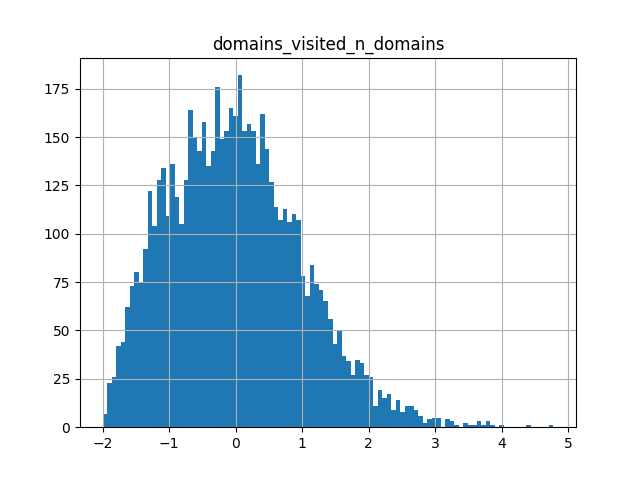

In [35]:
final_features[['domains_visited_n_domains']].hist(bins=100)

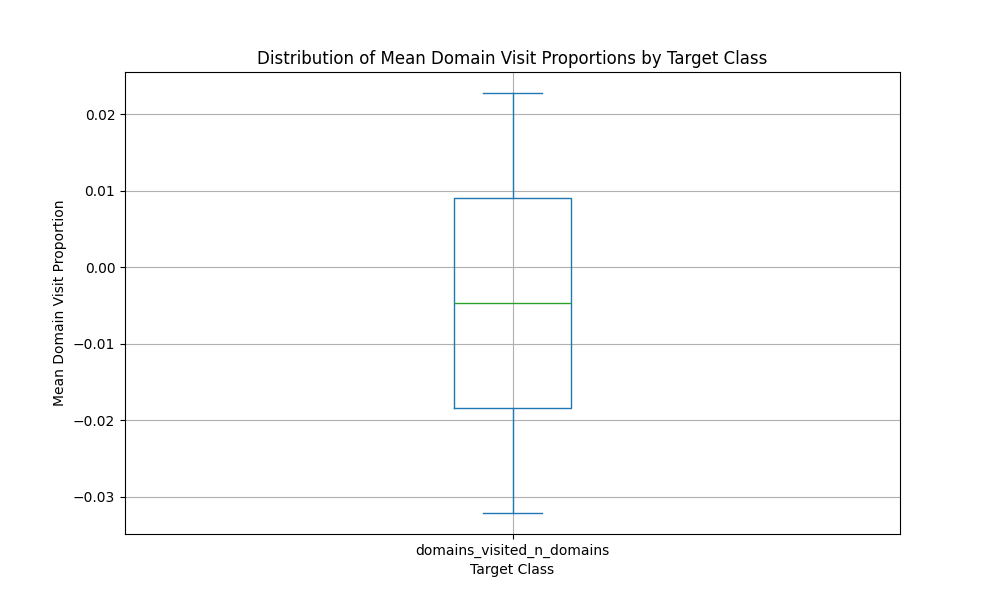

Mean difference (Target 1 - Target 0): -0.055
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/tom.touati/web-segmentation/e/WEB-114/metadata


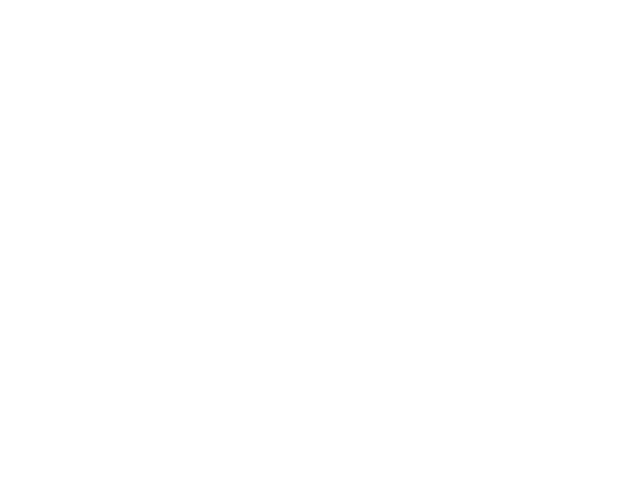

In [37]:
# Get predictions with binary classification
predictions_binary = test_prediction > 0.5

# Create masks for correct and incorrect predictions
correct_mask = predictions_binary == y_test
incorrect_mask = ~correct_mask

# Get feature columns with domains_visited_ prefix
domains_visited_cols = [
    col for col in final_features.columns if col.startswith('domains_visited_n_domains')]

# Create separate histograms for correct and incorrect predictions
plt.figure(figsize=(10, 6))

# Plot means by target value
final_features[['domains_visited_n_domains']].join(device_targets.set_index("Device_ID")
                                                   ).groupby("Target")["domains_visited_n_domains"].mean().T.plot(kind='box')

plt.title('Distribution of Mean Domain Visit Proportions by Target Class')
plt.xlabel('Target Class')
plt.ylabel('Mean Domain Visit Proportion')
plt.grid(True)
plt.show()

# Print mean differences
means_by_target = final_features[["domains_visited_n_domains"]].join(
    device_targets.set_index("Device_ID")).groupby("Target")["domains_visited_n_domains"].mean()
mean_diff = means_by_target.loc[1] - means_by_target.loc[0]
print(f"Mean difference (Target 1 - Target 0): {mean_diff.mean():.3f}")

run["plots/domain_visit_means"].upload(
    neptune.types.File.as_image(plt.figure()))
run.stop()

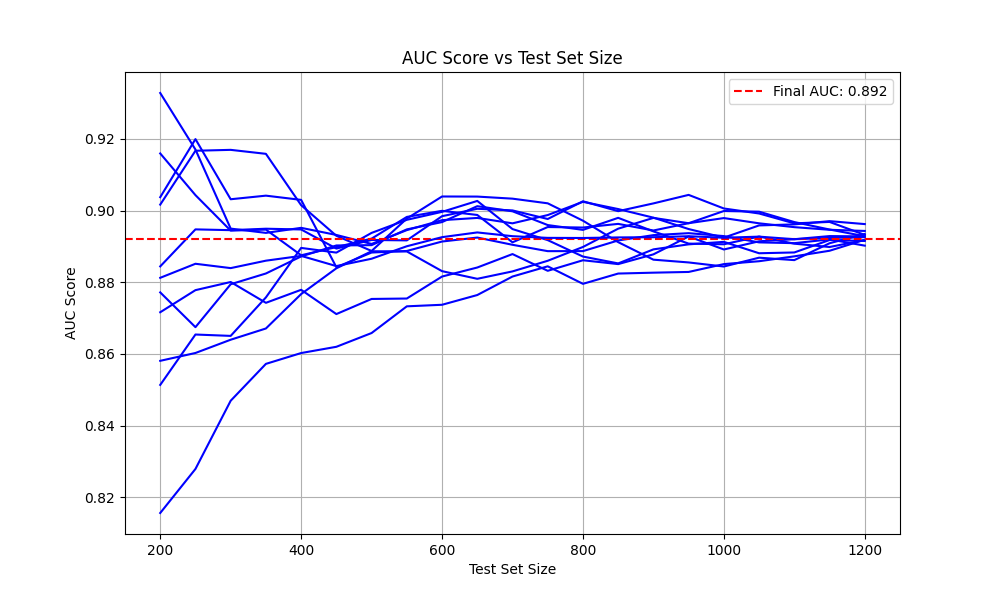

Mean AUC: 0.899
Std AUC: 0.009
95% CI: [0.881, 0.917]


In [27]:
import numpy as np
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Create test size increments
step = 50
max_size = len(y_test)
idx = np.arange(max_size)
auc_scores_all = []
for _ in range(10):
    np.random.shuffle(idx)
    y_check = y_test[idx]
    prediction_check = test_prediction[idx]
    sizes = np.arange(200, max_size, step)
    auc_scores = []

    # Calculate AUC for each size
    for size in sizes:
        auc = roc_auc_score(y_check[:size], prediction_check[:size])
        auc_scores.append(auc)
    auc_scores_all.append(auc_scores)
    plt.plot(sizes, auc_scores, 'b-', alpha=1)
# Calculate mean and std across runs
auc_scores_mean = np.mean(auc_scores_all, axis=0)
auc_scores_std = np.std(auc_scores_all, axis=0)

# Plot results


plt.axhline(y=score, color='r', linestyle='--',
            label=f'Final AUC: {score:.3f}')
plt.plot(sizes, auc_scores_mean, 'b-', alpha=1)

plt.title('AUC Score vs Test Set Size')
plt.xlabel('Test Set Size')
plt.ylabel('AUC Score')
plt.grid(True)
plt.legend()
plt.show()

# Print statistics
print(f'Mean AUC: {np.mean(auc_scores):.3f}')
print(f'Std AUC: {np.std(auc_scores):.3f}')
# Calculate confidence intervals
ci_upper = np.array(auc_scores) + 1.96 * np.std(auc_scores)
ci_lower = np.array(auc_scores) - 1.96 * np.std(auc_scores)

# Upload plot to neptune run
# run["plots/auc_vs_size"].upload(plt.gcf())
# run.stop()
# Print additional statistics
print(f'95% CI: [{np.mean(auc_scores)-1.96*np.std(auc_scores):.3f}, {np.mean(auc_scores)+1.96*np.std(auc_scores):.3f}]')

In [23]:
# # Plot training AUC-ROC history
# evals_result = selector.estimator_.evals_result()

# plt.figure(figsize=(10, 6))
# plt.plot(range(len(evals_result['validation_0']['auc'])),
#          evals_result['validation_0']['auc'],
#          'b-', label='Training AUC')

# plt.title('AUC-ROC Score Timeline')
# plt.xlabel('Iteration')
# plt.ylabel('AUC-ROC Score')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Print final AUC
# print(f'Final AUC-ROC Score: {score:.3f}')

In [ ]:
from sklearn.metrics import accuracy_score
y_train_pred = selector.estimator_.predict(X_train[best_features])

print(accuracy_score(y_train, y_train_pred > 0.5))
print(accuracy_score(y_test, test_prediction > 0.5))
cm = confusion_matrix(y_test, test_prediction > 0.5, normalize='true')

# create confusion matrix heatmap
plt.figure(figsize=(8, 6))
# Create heatmap with percentage values
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix (% of true labels)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
# Plot training and validation metrics
plt.figure(figsize=(10, 6))

# Calculate accuracy for different thresholds
thresholds = np.linspace(0, 1, 100)
accuracies = [accuracy_score(y_test, test_prediction > t) for t in thresholds]

# Plot accuracy vs threshold curve
plt.plot(thresholds, accuracies, label='Accuracy')

# Add vertical line at 0.5 threshold
plt.axvline(x=0.5, color='r', linestyle='--', label='0.5 threshold')

# Add horizontal line at max accuracy
max_accuracy = max(accuracies)
plt.axhline(y=max_accuracy, color='g', linestyle='--',
            label=f'Max accuracy: {max_accuracy:.3f}')

plt.title('Model Performance on Validation Set')
plt.xlabel('Prediction Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Print additional metrics
optimal_threshold = thresholds[np.argmax(accuracies)]
print(f'Optimal threshold: {optimal_threshold:.3f}')
print(f'ROC AUC score: {score:.3f}')

In [26]:
def full_data_train_and_save(final_features):
    final_x = final_features.drop("Target", axis=1)
    final_y = final_features["Target"]
    full_data_model, full_data_features = train_model(
        final_x, final_y, params=params["model"])
    import json
    with open("submission/best_features.json", "w") as fp:
        json.dump(full_data_features, fp)
    import os
    os.makedirs("submission", exist_ok=True)
    # with open("submission/XGB_model.json", "w") as fp:
    full_data_model.estimator_.save_model('submission/XGB_model.json')
    return full_data_model

In [27]:
import os
os.makedirs("submission", exist_ok=True)
# with open("submission/XGB_model.json", "w") as fp:
selector.estimator_.save_model('submission/XGB_model.json')

In [28]:


import xgboost
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import json
from domain_timeseries_processing import *
from utils import *
from load_and_prepare_input import *
from prepare_and_train_model import *
from content_based_features import *
from frequency_base_feats import *


class model:
    def __init__(self, with_neptune=False):
        '''
        Init the model
        '''
        self.model = xgboost.XGBRegressor()
        self.domain_activity = None
        self.user_activity = None
        self.best_features = None
        self.score_scaler = MinMaxScaler(feature_range=(-1, 1))

    def get_probability_score(self, x_domains):
        user_activity_timeseries = get_user_activity_timeseries(
            x_domains, self.params["user_activity_timeseries"])

        p_scores_df = get_user_domain_scores(
            self.domain_activity, user_activity_timeseries)
        p_scores_df -= 0.5
        min_max_scale_all_values(p_scores_df, train_devices, self.score_scaler)
        return p_scores_df

    def get_content_based_features(self, db_df, x_domains):
        domain_usage_proportion = get_domain_usage_proportion(
            x_domains)
        domain_usage_proportion = np.log(1+domain_usage_proportion)
        domain_usage_proportion = (
            (domain_usage_proportion.T)/domain_usage_proportion.T.max()).T
        cls_data = get_cls_data(db_df)
        cls_proportion = get_cls_proportion(cls_data)
        return domain_usage_proportion, cls_proportion

    def get_frequency_based_features(self, db_df, user_activity_timeseries):
        psd_df = get_ps_df(user_activity_timeseries, train_devices)

        domains_visited_proportion = get_proportion_of_domains_visited(
            db_df[db_df["Domain_Name"].isin(devices_per_valid_domain.index)])
        z_normalize_by_all(
            domains_visited_proportion, train_devices, per_column=True, fillval=0, scaler=self.domain_visit_scaler)
        return psd_df, domains_visited_proportion, n_valid_sites_per_user

    def get_mixed_features(self, p_scores_df, domain_usage_proportion):
        weighted_final_scores = get_weighted_final_scores(
            p_scores_df, domain_usage_proportion)
        # add mean and std of weighted_final_scores
        return weighted_final_scores, weighted_final_scores.T.mean(), weighted_final_scores.T.std()

    def load_standard_scaler(self, scaler_path):
        '''
        Load the StandardScaler from the given path
        '''
        with open(scaler_path, 'r') as f:
            loaded_params = json.load(f)
        scaler = StandardScaler()
        scaler.mean_ = np.array(
            [loaded_params["mean_"]], dtype=np.float64)
        scaler.var_ = np.array(
            [loaded_params["var_"]], dtype=np.float64)
        scaler.scale_ = np.array(
            [loaded_params["scale_"]], dtype=np.float64)
        scaler.n_samples_seen_ = np.array(
            [loaded_params["n_samples_seen_"]], dtype=np.int64)
        return scaler

    def load_minmax_scaler(self, scaler_path):
        '''
        Load the MinMaxScaler from the given path
        '''
        with open(scaler_path, 'r') as f:
            loaded_params = json.load(f)
        scaler = MinMaxScaler()
        scaler.min_ = np.array(
            [loaded_params["min_"]], dtype=np.float64)
        scaler.scale_ = np.array(
            [loaded_params["scale_"]], dtype=np.float64)
        scaler.data_min_ = np.array(
            [loaded_params["data_min_"]], dtype=np.float64)
        scaler.data_max_ = np.array(
            [loaded_params["data_max_"]], dtype=np.float64)
        scaler.data_range_ = np.array(
            [loaded_params["data_range_"]], dtype=np.float64)
        scaler.feature_range = tuple(loaded_params["feature_range"])
        return scaler

    def load(self, dir_path):
        '''
        Load the trained model and domain activity data
        '''
        import os
        import json

        model_path = os.path.join(dir_path, 'XGB_model.json')
        self.model.load_model(model_path)
        best_features_path = os.path.join(dir_path, 'best_features.json')
        with open(best_features_path, "r") as fp:
            self.best_features = json.load(fp)
        self.best_domains = [x for x in self.best_features if x.isnumeric()]
        domain_activity_path = os.path.join(
            dir_path, 'best_domain_activity.parquet')
        self.domain_activity = pd.read_parquet(domain_activity_path)
        self.load_minmax_scaler(os.path.join(dir_path, 'minmax_scaler.json'))

    def predict(self, X):
        '''
        Predict the class probability for the input data
        '''
        # Process user timeseries
        X = X.copy()

        if X['Datetime'].dtype == 'O':
            X['Datetime'] = pd.to_datetime(X['Datetime'])
        if "Device_ID" not in X.columns:
            X["Device_ID"] = 1
        X.set_index(['Datetime'], inplace=True)
        x_domains = X[X['Domain_Name'].isin(
            [int(x) for x in self.best_domains])]

        cls_proportion = self.get_cls_proportion(X)
        final_features = pd.concat([final_scores.reset_index(
        ), cls_proportion.reset_index()], axis=1)[self.best_features]
        # Make prediction
        prediction = self.model.predict(final_features)
        return prediction[0]

In [29]:
test_df = db_df[db_df["Device_ID"].isin(test_device_ids)].reset_index()

In [30]:
sys.path.append("/home/tom.touati/mafat-challenge/code/submission/model.py")